In [2]:
import tensorflow as tf # pip install tensorflow
import cv2 ## pip install opencv-python
## pip install opencv-contrib-python fullpackage
import speech_recognition
import os
import matplotlib.pyplot as plt
import numpy as np

In [3]:
!pip list


Package                      Version
---------------------------- -------------------
absl-py                      1.0.0
asttokens                    2.0.5
astunparse                   1.6.3
backcall                     0.2.0
beautifulsoup4               4.11.1
bs4                          0.0.1
cachetools                   5.0.0
certifi                      2021.10.8
charset-normalizer           2.0.12
click                        8.1.3
colorama                     0.4.4
comtypes                     1.1.11
cycler                       0.11.0
debugpy                      1.6.0
decorator                    5.1.1
distlib                      0.3.4
docopt                       0.6.2
entrypoints                  0.4
executing                    0.8.3
filelock                     3.7.1
Flask                        2.1.2
flatbuffers                  1.12
fonttools                    4.33.3
gast                         0.4.0
google-auth                  2.6.6
google-auth-oauthlib         0.4.

In [4]:
img_array=cv2.imread("D:/Projects/Drowsiness Detection/Train Dataset/Closed_eyes/s0001_00004_0_0_0_0_0_01.png",cv2.IMREAD_GRAYSCALE)

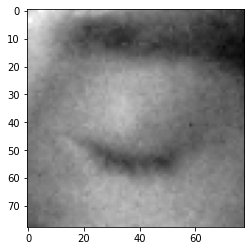

In [5]:
plt.imshow(img_array,cmap='gray')

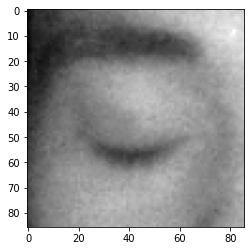

In [6]:
Datadirectory="D:/Projects/Drowsiness Detection/Train Dataset/"  ## training dataset
Classes=["CLosed_Eyes","Open_Eyes"] ## list of classes
for category in Classes:
    path=os.path.join(Datadirectory,category) ##//
    for img in os.listdir(path):
        img_array=cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
        backtorgb=cv2.cvtColor(img_array,cv2.COLOR_GRAY2RGB)
        plt.imshow(img_array,cmap="gray")
        plt.show()
        break
    break

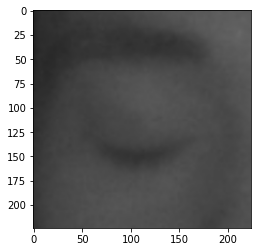

In [7]:
img_size=224
new_array=cv2.resize(backtorgb,(img_size,img_size))
plt.imshow(new_array,cmap="gray")
plt.show()

### Reading all the images and converting them into an array for data and labels

In [6]:
training_Data=[]
def create_training_Data():
    for category in Classes:
        path=os.path.join(Datadirectory,category) ## 0,1
        class_num=Classes.index(category)
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                backtorgb=cv2.cvtColor(img_array,cv2.COLOR_GRAY2RGB)
                new_array=cv2.resize(backtorgb, (img_size,img_size))
                training_Data.append([new_array,class_num])
            except Exception as e:
                pass

In [7]:
create_training_Data()

In [8]:
print(len(training_Data))

3202


In [9]:
import random
random.shuffle(training_Data)

In [10]:
X=[]
y=[]
for features ,label in training_Data:
    X.append(features)
    y.append(label)
X=np.array(X).reshape(-1,img_size,img_size,3)

In [11]:
X.shape

(3202, 224, 224, 3)

In [12]:
# normalize the data
X=X/255.0  ## we are normalizing it

In [13]:
Y=np.array(y)

In [14]:
# Saving data
import pickle
pickle_out=open("X.pickle","wb")
pickle.dump(X,pickle_out)
pickle_out.close()

pickle_out=open("y.pickle","wb")
pickle.dump(y,pickle_out)
pickle_out.close()

In [15]:
# To load the data from pickle file
pickle_in=open("X.pickle","rb")
X=pickle.load(pickle_in)

pickle_in=open("y.pickle","rb")
y=pickle.load(pickle_in)

### deep learning model for training -Training Learning

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [17]:
model=tf.keras.applications.mobilenet.MobileNet()

In [18]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

### Transfer Learning

In [19]:
base_input=model.layers[0].input  ## input

In [20]:
base_output=model.layers[-4].output

In [21]:
Flat_layers=layers.Flatten()(base_output)
final_output=layers.Dense(1)(Flat_layers) ## one node(1)
final_output=layers.Activation('sigmoid')(final_output)

In [22]:
new_model=keras.Model(inputs=base_input,outputs=final_output)

In [23]:
# for layer in model.layers:
#     layer.trainablea=false

In [24]:
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

## Settings for Binary Classification(Open/Closed)

In [25]:
new_model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

In [26]:
# new_model.fit(X,Y,epochs=50,validation_split=0.1) ## training

In [27]:
from keras.callbacks import ModelCheckpoint  #save the best model
from keras.callbacks import EarlyStopping  #save time
checkpoint=ModelCheckpoint("mymodel.h5",monitor='val_accuracy',verbose=0,save_weights_only=False,mode='auto',period=1)
earlystop=EarlyStopping(monitor='val_accuracy',patience=3)
new_model.fit(X,Y,validation_split=0.2,epochs=50,callbacks=[checkpoint,earlystop])

Epoch 1/50
81/81 [==============================] - 298s 4s/step - loss: 0.1721 - accuracy: 0.9438 - val_loss: 4.5124 - val_accuracy: 0.5554
Epoch 2/50
81/81 [==============================] - 347s 4s/step - loss: 0.0744 - accuracy: 0.9672 - val_loss: 0.1557 - val_accuracy: 0.9345
Epoch 3/50
81/81 [==============================] - 355s 4s/step - loss: 0.0434 - accuracy: 0.9840 - val_loss: 0.3487 - val_accuracy: 0.8939
Epoch 4/50
81/81 [==============================] - 339s 4s/step - loss: 0.0702 - accuracy: 0.9707 - val_loss: 0.2182 - val_accuracy: 0.9516
Epoch 5/50
81/81 [==============================] - 321s 4s/step - loss: 0.0668 - accuracy: 0.9766 - val_loss: 0.1824 - val_accuracy: 0.9532
Epoch 6/50
81/81 [==============================] - 311s 4s/step - loss: 0.0268 - accuracy: 0.9895 - val_loss: 0.0650 - val_accuracy: 0.9860
Epoch 7/50
81/81 [==============================] - 267s 3s/step - loss: 0.0099 - accuracy: 0.9957 - val_loss: 0.0975 - val_accuracy: 0.9828
Epoch 8/50
81

In [27]:
# new_model.save("mymodel.h5")

In [14]:
new_model=tf.keras.models.load_model('mymodel.h5')

### Checking the network for predictions

In [15]:
img_array=cv2.imread('D:/Projects/Drowsiness Detection/Train Dataset/Closed_eyes/s0001_00003_0_0_0_0_0_01.png',cv2.IMREAD_GRAYSCALE)
backtorgb=cv2.cvtColor(img_array,cv2.COLOR_GRAY2RGB)
new_array=cv2.resize(backtorgb, (img_size,img_size))

In [16]:
X_input=np.array(new_array).reshape(1,img_size,img_size,3)

In [17]:
X_input.shape

(1, 224, 224, 3)

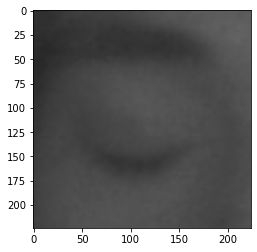

In [18]:
plt.imshow(new_array)

In [19]:
X_input=X_input/255.0

In [20]:
prediction=new_model.predict(X_input)

In [21]:
prediction

array([[5.6376816e-06]], dtype=float32)

### Lets check on unknown Images

In [22]:
img=cv2.imread('D:/Projects/Drowsiness Detection/Real.jpg')
img.shape

(408, 612, 3)

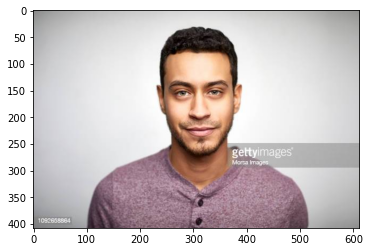

In [23]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [24]:
faceCascade=cv2.CascadeClassifier('D:\\tanuj_document\\sublime_text_app\\haarcascade_frontalface_default.xml') 

In [25]:
# eye_cascade=cv2.CascadeClassifier("D:\\Projects\\Drowsiness Detection\\haarcascade_eye.xml")
#eye_cascade=cv2.CascadeClassifier('D:\\tanuj_document\\sublime text app\\haarcascade_eye.xml')
eye_cascade=cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_eye.xml')

In [26]:
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#plt.imshow(gray,cmap='gray')

In [27]:
eyes=eye_cascade.detectMultiScale(gray,1.3,5)

In [28]:
for(x,y,w,h) in eyes:
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0) ,2)

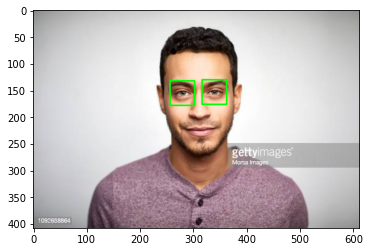

In [29]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

### Cropping the Eye from image

In [30]:
eye_cascade=cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_eye.xml')
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  #print(faceCascade.empty())
eyes=eye_cascade.detectMultiScale(gray,1.1,4)
for x,y,w,h in eyes:
    roi_gray=gray[y:y+h, x:x+w]
    roi_color=img[y:y+h, x:x+w]
    eyess=eye_cascade.detectMultiScale(roi_gray)
    if(len(eyess)==0):
        print("eyes are not detected")
    else:
        for(ex,ey,ew,eh) in eyess:
            eyes_roi=roi_color[ey: ey+eh,ex:ex+ew]

In [31]:
eyes

array([[317, 131,  43,  43],
       [257, 134,  41,  41]])

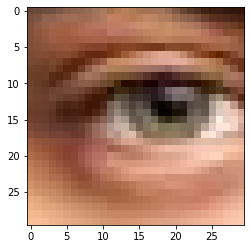

In [71]:
plt.imshow(cv2.cvtColor(eyes_roi,cv2.COLOR_BGR2RGB))

In [72]:
eyes_roi.shape

(30, 30, 3)

In [73]:
final_image=cv2.resize(eyes_roi,(224,224))
final_image=np.expand_dims(final_image,axis=0)
final_image=final_image/255.0

In [74]:
final_image.shape

(1, 224, 224, 3)

In [75]:
new_model.predict(final_image)

array([[0.63510025]], dtype=float32)

### If eyes are closed for unusual time,like more than blinks,for few seconds alaram Generated

In [20]:
import winsound
frequency=2500  # Set Frequency to 2500 Hertz
duration=1000  # Set Duration To 1000 ms ==1 second
import numpy as np
import cv2 
# from deepface import DeepFace ## pip install deepface
path="D:\\tanuj_document\\sublime_text_app\\haarcascade_frontalface_default.xml"
faceCascade=cv2.CascadeClassifier("D:\\tanuj_document\\sublime_text_app\\haarcascade_frontalface_default.xml") 
cap=cv2.VideoCapture(1)
# Check if the webcam is opened correctly
if not cap.isOpened():
    cap=cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot open webcam")
counter=0
while True:
    ret,frame=cap.read()
    eye_cascade=cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_eye.xml')
    gray=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    #print(faceCascade.empty())
    eyes=eye_cascade.detectMultiScale(gray,1.1,4)
    for x,y,w,h in eyes:
        roi_gray=gray[y:y+h, x:x+w]
        roi_color=frame[y:y+h, x:x+w]
        cv2.rectangle(frame,(x,y),(x+w,y+h), (0,255,0), 2)
        eyess=eye_cascade.detectMultiScale(roi_gray)
        if len(eyess)==0:
            print("eyes are not detected")
        else :
            for(ex,ey,ew,eh) in eyess:
                eyes_roi=roi_color[ey: ey+eh, ex:ex+ew]
    gray=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    print(faceCascade.empty())
    faces=faceCascade.detectMultiScale(gray,1.1,4)
    
    # Draw a rectangle around the faces
    for(x,y,w,h) in faces:
        cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)
    
    font=cv2.FONT_HERSHEY_SIMPLEX
    # Use putText() method for
    # inserting text on video
    
    final_image=cv2.resize(eyes_roi,(224,224))
    final_image=np.expand_dims(final_image,axis=0)  ## need fourth dimension
    final_imagel_image=final_image/255.0
    
    Predictions=new_model.predict(final_image)
    if(Predictions>0.04):
        status="Open Eyes"
        cv2.putText(frame,
                   str(Predictions),
                   (150,150),
                   font,1,
                   (0,255,0),
                   2,
                   cv2.LINE_4)
        x1,y1,w1,h1=0,0,175,75
        # Draw black background rectangle
        cv2.rectangle(frame,(x1,x1), (x1+w1,y1+h1), (0,0,0),-1)
        # ADD Text
        cv2.putText(frame,'Active',(x1+int(w1/10),y1+int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0),2)
    else:
        counter=counter+1
        status="Closed Eyes"
        cv2.putText(frame,
                   str(Predictions),(150,150),
                   font,1,
                    (0,0,255),
                    2,
                    cv2.LINE_4)
        cv2.rectangle(frame,(x,y), (x+w, y+h), (0,0,255), 2)
        if counter>5:
            x1,y1,w1,h1=0,0,175,175
            #Draw black Diagram rectangle
            cv2.rectangle(frame,(x1,x1),(x1+w1,y1+h1),(0,0,0),-1)
            #Add Text
            #cv2.putText(frame,'Sleep Alert ||',(x1,int(w1/50),y1+int(h1/10)),cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,0,255),2)
            winsound.Beep(frequency,duration)
            counter=0
    cv2.imshow("Video Frame",frame)
   # cv2.imshow("frame_crop_image",face_section)
   # cv2.imshow("gray video frame",gray_frame)
    
    if cv2.waitKey(1)&0xFF==ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

False
eyes are not detected
False
False
eyes are not detected
False
eyes are not detected
False
eyes are not detected
False
False
False
False
False
eyes are not detected
False
False
False
False
eyes are not detected
False
False
False
eyes are not detected
False
False
False
False
False
False
eyes are not detected
False
eyes are not detected
False
False
False
False
eyes are not detected
eyes are not detected
False
eyes are not detected
False
eyes are not detected
eyes are not detected
False
False
False
False
False
False
eyes are not detected
False
False
False
eyes are not detected
False
eyes are not detected
False
False
False
eyes are not detected
eyes are not detected
False
False
eyes are not detected
False
eyes are not detected
False
False
eyes are not detected
False
eyes are not detected
False
False
False
False
False
False
False
False
eyes are not detected
eyes are not detected
False
eyes are not detected
False
eyes are not detected
False
eyes are not detected
False
eyes are not detec

In [1]:
font

NameError: name 'font' is not defined

In [6]:
cv2.imshow('img',img)


In [4]:
img=cv2.imread('D:/tanuj_document/sublime_text_app/Computer Vision/cigar.png')


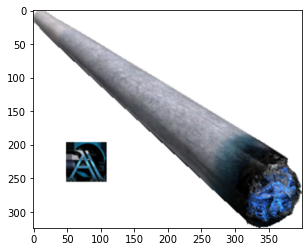

In [5]:
plt.imshow(img)